# Convolutions based FD loss function implementation

## 1. Introduction

In this workbook, we cover the usage of DiffNets to solve Poisson's Equation. The Poisson equation for the scalar field $u({\bf x})$ can be written as

$$
\begin{align}
-\nabla \cdot (\nu({\bf x}) \nabla u({\bf x})) &= f({\bf x}) \ \textrm{ in } D\\
u &= 0 \ \textrm{ on } \partial D
\end{align}
$$

where, the domain $D = [0,1]^2$ is the unit square; ${\bf x} = (x,y)$ represents the independent variables, $\nu({\bf x})$ represents the *diffusivity* (or *permeability*) of the medium, and $ f(\bf x)$ is the external forcing. In this example, we take $ f({\bf x}) = 2 \pi^2 \sin(\pi x) \sin(\pi y)  $ and $\nu({\bf x}) = 1$. With this forcing, there exists an exact solution given by $u_{ex} = \sin(\pi x) \sin(\pi y)$.

However, instead of solving the Poisson's Equation by setting up algebraic equations, here we use convolution based loss function inspired by the finite difference method (FDM). Since we know the exact solution for the above set of equations, we can validate this approach by explicitly calculating the errors.

## 2. DiffNet
A trained DiffNet can take a full field of diffusivity (or forcing) and map it to the full field solution. For example, in the below schematic, we see a trained DiffNet $G_{nn}$ takes a matrix $S^d$ (numerical version of $\nu({\bf x})$) as input and map it to another matrix $U^d$ (approximated version of $u({\bf x}))$:
![](https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/xdiffnet-scheme.png)
Both $S^d$ and $U^d$ are matrices (or images) of the same size ($6\times 6$ or, $5\times 5$ "finite elements").

Given such discretized representations, DiffNet solves the Poisson's equation by minimizing the residual of finite difference equations, i.e., define
$$
J(u) = \|R\|_p = \| {\mathbf A}\text{ }{\mathbf U^d} - {\mathbf f} \|_p, \ (p\in\{1,2\})
$$
and the solution is then given by:
$$
u = \arg\min J(u).
$$

In this tutorial, we will directly minimize $J(u)$ without a neural network. This means that $G_{nn}$ is not really a neural network, but can be thought of as a function that simply takes only one instance of $f$ and outputs the solution. For any $f$ other than the one used during the optimization, $G_{nn}$ will give nonsense results. But the methodology discussed here is the same when a neural network is used (see `03 poisson-manufactured-fem-network.ipynb`) (for a finite element (FEM) loss).

The DiffNet library provides in-built capability to approximate full field solutions at the FD grid points and the mechanism to calculate finite difference derivatives using convolution kernels. To use these features for solving the Poisson's equation, we need to implement two classes:
1. A dataset class `DataRectangle` (derived from `torch.utils.Dataset`): to implement the diffusivity, forcing and the boundary conditions.
2. An equation class `Poisson` (derived from `DiffNet.DiffNetFDM`): to implement the loss function, training step, optimizer configuration, query step etc.

## 3. Imports
We begin with few imports

In [1]:
import os
import sys
import json
import math
import torch
import numpy as np
from torch import nn

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFDM import DiffNetFDM
from torch.utils import data

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42


# 4. Dataset class
Suppose we discretize the 2D domain into regularly spaced $N\times N$ grid points.

The `DataRectangle` class holds the given "input data" of the equation, i.e., the diffusivity ($\nu$), forcing ($f$) and the boundary conditions ($u_{\partial D}$). The important thing to note here is that, since DiffNet is based on full-field calculations, all three of these data need to be stored in tensor format. In particular, since the current equation is defined on a 2D square domain, we store each of $\nu$, $f$ and $u_{\partial D}$ in 2D matrices of size $N\times N$.

In [2]:
class DataRectangle(data.Dataset):
    'PyTorch dataset for sampling coefficients'
    def __init__(self, domain_size=64):
        """
        Initialization
        """
        self.domain = np.ones((domain_size, domain_size))
        # bc1 will be source, u will be set to 1 at these locations
        self.bc1 = np.zeros((domain_size, domain_size))
        # bc2 will be sink, u will be set to 0 at these locations
        self.bc2 = np.zeros((domain_size, domain_size))
        self.bc2[-1,:] = 1
        self.bc2[0,:] = 1
        self.bc2[:,0] = 1
        self.bc2[:,-1] = 1
        self.n_samples = 100
        x = np.linspace(0,1,domain_size)
        y = np.linspace(0,1,domain_size)
        xx, yy = np.meshgrid(x,y)
        self.forcing = 2. * math.pi**2 * np.sin(math.pi * xx) * np.sin(math.pi * yy)
        

    def __len__(self):
        'Denotes the total number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generates one sample of data'
        inputs = np.array([self.domain, self.bc1, self.bc2])
        forcing = self.forcing
        return torch.FloatTensor(inputs), torch.FloatTensor(forcing).unsqueeze(0)

## 5. Equation class

Now we need to define the equation class `Poisson` that inherits the `DiffNet.DiffNetFDM` class which in turn inherits the `LightningModule` class from `pytorch_lightning.core`. The main purpose of `Poisson` is to implement the training step and the loss function along with optimizer configurations (if necessary). Let us discuss them one by one:
* `training_step`: this function will be called by `PytorchLightning` every training step with an input `batch`. This `batch` represents the data for a minibatch and is obtained by `PytorchLightning` by calling the `__getitem__` function in the `DataRectangle` class.
* `loss(u, I, f)`: the loss function can be implemented in many ways, but essentially takes the data of the equation and calculates the loss value. In this implementation `loss` takes the currently predicted field `u` and the other inputs (BC, nu, f). Inside this function, we evaluate the residual $J(u) = \|R\|_2 = \| {\mathbf A}\text{ }{\mathbf U^d} - {\mathbf f} \|_2 $. This is an important step and is done as follows:
    * Extract `nu` and `bc` from `imputs_tensor`
    * Apply the boundary conditions on `u` using the boundary masks (i.e., `bc1` and `bc2` that contain zeros in the interior points, and ones on the boundary points.
    * Now we need to evaluate the residual tensor `R`. Each element of `R` is the residual of the Poisson's equation evaluated on the corresponding grid point. We already have `f` and `nu` available at the grid points. So we just need to evaluate the Laplacian at the grid points. This is done by performing 2D convolution of the tensor `u` with one of the derivative kernels (`sobelx, sobely, sobelxx` and `sobelyy`) available to this class. For example, to evaluate $\frac{\partial u}{\partial x}$ at all the grid points, we simply call `u_x = nn.functional.conv2d(u, self.sobelx)` and so on.
    * Once all the derivative values are evaluated on the grid points, the next step is to simply write down the residual tensor using those data, and then taking the suitable norm gives the loss function.
* Along with the above two functions, some other auxiliary functions can be added to this class as needed, e.g., `do_query`, `plot_contours`, `on_epoch_end` etc.
* `on_epoch_end` is called by `PytorchLightning` at the end of each epoch during training. We can plot the current `u` vlaue at the end of each epoch by implementing this function accordingly.

In [3]:
class Poisson(DiffNetFDM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)
        x = np.linspace(0,1,self.domain_size)
        y = np.linspace(0,1,self.domain_size)
        xx, yy = np.meshgrid(x,y)
        self.u_exact = torch.tensor(np.sin(np.pi*xx)*np.sin(np.pi*yy))

        self.h = 1. / (self.domain_size - 1)

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        # u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)

        u_x = nn.functional.conv2d(u, self.sobelx)
        u_y = nn.functional.conv2d(u, self.sobely)
        u_xx = nn.functional.conv2d(u, self.sobelxx)
        u_yy = nn.functional.conv2d(u, self.sobelyy)
        u_laplacian = u_xx + u_yy

        nu_x = nn.functional.conv2d(nu, self.sobelx)
        nu_y = nn.functional.conv2d(nu, self.sobely)

        gradU_DOT_gradNU = torch.mul(u_x, nu_x) + torch.mul(u_y, nu_y)


        res = f[:,:,1:-1,1:-1] + gradU_DOT_gradNU + torch.mul(nu[:,:,1:-1,1:-1], u_laplacian)

        loss2 = torch.norm(res.view(u.shape[0], -1), p=2, dim=1)

        return loss2


    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        return self.network[0], inputs_tensor, forcing_tensor

    def configure_optimizers(self):
        """
        Configure optimizer for network parameters
        """
        # lr = self.learning_rate
        opts = [torch.optim.LBFGS(self.network, lr=0.1, max_iter=4)]
        schd = []
        schd = [torch.optim.lr_scheduler.MultiStepLR(opts[0], milestones=[2,5,10], gamma=0.1)]
        return opts, schd
    
    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.unsqueeze(0).type_as(next(self.network.parameters())), 
                                                         forcing.unsqueeze(0).type_as(next(self.network.parameters()))))
        
        f = forcing_tensor.squeeze().detach().cpu() # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]        
        # process diffusivity
        k = nu.squeeze().detach().cpu()

        # process u (by adding BC)
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)        
        u = u.squeeze().detach().cpu()
        
        return u, k, f
    
    def plot_contours_to_logger(self,k,f,u,u_exact):
        diff = u - u_exact
        # plotting        
        fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
        im = axs[0].imshow(f,cmap='jet')
        fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
        im = axs[1].imshow(k,cmap='jet')
        fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
        im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
        im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
        im = axs[4].imshow(diff,cmap='jet')
        fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
        # plt.show()
        plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all') 
        
    def plot_contours(self,k,f,u,u_exact):
        diff = u - u_exact
        # plotting        
        fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
        im = axs[0].imshow(f,cmap='jet')
        fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
        im = axs[1].imshow(k,cmap='jet')
        fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
        im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
        im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
        im = axs[4].imshow(diff,cmap='jet')
        fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
        plt.show()

    def on_epoch_end(self):
        self.network.eval()
        inputs, forcing = self.dataset[0]
        u, k, f = self.do_query(inputs, forcing)                
        
        u_exact = self.u_exact.squeeze().detach().cpu()
        diff = u - u_exact
        
        self.plot_contours_to_logger(k,f,u,u_exact)

## 4. Initializations

In [4]:
u_tensor = np.ones((1,1,64,64))
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
# dataset = Dataset('example-coefficients.txt', domain_size=64)
dataset = DataRectangle(domain_size=64)
basecase = Poisson(network, dataset, batch_size=1)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="fdm-mms")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=25, deterministic=True, profiler="simple")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


## 5. Training


In [5]:
trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))


  | Name    | Type          | Params
------------------------------------------
0 | network | ParameterList | 4.1 K 
------------------------------------------
4.1 K     Trainable params
54        Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Epoch 24: 100%|██████████| 100/100 [00:01<00:00, 62.94it/s, loss=2.17, v_num=3_3]   

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  39.277         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.5561         	|25             	|  38.904         	|  99.05          	|
run_training_batch                 	|  0.0068139      	|2500           	|  17.035         	|  43.372         	|
optimizer_step_and_closure_0       	|  0.0065894      	|2500           	|  16.473         	|  41.942         	|
on_epoch_end                       	|  0.6148         	|25             	|  15.37          	|  39.133         	|
training_step_and_backward         

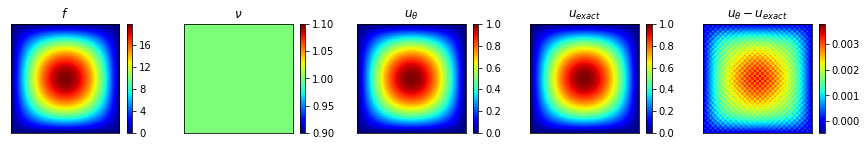

In [6]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u, k, f = basecase.do_query(inputs, forcing) 
u_exact = basecase.u_exact.squeeze().detach().cpu()
# plot
basecase.plot_contours(k,f,u,u_exact)